In [12]:
import pandas as pd
import numpy as np
import pandas_ta as pta
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import datetime

# Í∑∏ÎûòÌîÑ Ïä§ÌÉÄÏùº ÏÑ§Ï†ï
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# NASDAQ Ï¢ÖÎ™© Î™©Î°ù Í∞ÄÏ†∏Ïò§Í∏∞
# ---------------------------
print("üìú NASDAQ Ï†ÑÏ≤¥ Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏Î•º Í∞ÄÏ†∏ÏôÄ ÏÉÅÏúÑ 100Í∞úÎ•º ÏÑ†ÌÉùÌï©ÎãàÎã§...")
nasdaq_list = fdr.StockListing('NASDAQ')

# Ï†ÑÏ≤¥ Î™©Î°ùÏóêÏÑú ÏïåÌååÎ≤≥ ÏàúÏÑúÎåÄÎ°ú 100Í∞úÎßå ÏÑ†ÌÉù
nasdaq_100_df = nasdaq_list.head(100)

tickers = nasdaq_100_df['Symbol'].tolist()
print(f"‚úÖ Ï¥ù {len(tickers)}Í∞úÏùò Ï¢ÖÎ™©ÏùÑ ÌôïÏù∏ÌñàÏäµÎãàÎã§.")
stock_names_df = nasdaq_100_df.set_index('Symbol')

üìú NASDAQ Ï†ÑÏ≤¥ Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏Î•º Í∞ÄÏ†∏ÏôÄ ÏÉÅÏúÑ 100Í∞úÎ•º ÏÑ†ÌÉùÌï©ÎãàÎã§...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3694/3694 [00:09<00:00, 400.04it/s]


‚úÖ Ï¥ù 100Í∞úÏùò Ï¢ÖÎ™©ÏùÑ ÌôïÏù∏ÌñàÏäµÎãàÎã§.


In [13]:
# ---------------------------
# Í∏àÏúµ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
# ---------------------------
start_date = '2022-01-01'
end_date = datetime.date.today().strftime('%Y-%m-%d')
all_data = {}

print("üìà NASDAQ Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ ÏàòÏßëÏùÑ ÏãúÏûëÌï©ÎãàÎã§...")
for ticker in tickers:
    try:
        stock_name = stock_names_df.loc[ticker, 'Name']
        df = fdr.DataReader(ticker, start_date, end_date)
        
        if df.empty:
            print(f"‚ö†Ô∏è {stock_name} ({ticker}) Îç∞Ïù¥ÌÑ∞Î•º Í∞ÄÏ†∏Ïò¨ Ïàò ÏóÜÏäµÎãàÎã§. Í±¥ÎÑàÎúÅÎãàÎã§.")
            continue

        rename_dict = {'Open': 'PX_OPEN', 'High': 'PX_HIGH', 'Low': 'PX_LOW', 'Close': 'PX_LAST', 'Volume': 'PX_VOLUME'}
        df.rename(columns=rename_dict, inplace=True)
        
        if 'Change' in df.columns:
            df = df.drop(columns='Change')
            
        all_data[stock_name] = df
        print(f"- {stock_name} ({ticker}) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å")
    except Exception as e:
        print(f"‚ùå {ticker} Ï≤òÎ¶¨ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")

if not all_data:
    print("‚ùå ÏàòÏßëÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ Î∂ÑÏÑùÏùÑ Ï¢ÖÎ£åÌï©ÎãàÎã§.")
else:
    data = pd.concat(all_data, axis=1, keys=all_data.keys())
    data.index.name = 'Dates'
    data.columns.names = ['Ticker', 'Feature']
    print("‚úÖ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!")

üìà NASDAQ Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ ÏàòÏßëÏùÑ ÏãúÏûëÌï©ÎãàÎã§...
- NVIDIA Corp (NVDA) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Microsoft Corp (MSFT) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Apple Inc (AAPL) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Amazon.com Inc (AMZN) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Meta Platforms Inc (META) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Broadcom Inc (AVGO) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Alphabet Inc Class A (GOOGL) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Alphabet Inc Class C (GOOG) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Tesla Inc (TSLA) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Netflix Inc (NFLX) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Costco Wholesale Corp (COST) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Palantir Technologies Inc (PLTR) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- ASML Holding NV ADR (ASML) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- T-Mobile US Inc (TMUS) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Advanced Micro Devices Inc (AMD) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Cisco Systems Inc (CSCO) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- AstraZeneca PLC ADR (AZN) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- Linde PLC (LIN) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
- PepsiCo Inc (PEP) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å

In [14]:
# ---------------------------
# ÌäπÏßï Í≥µÌïô (Feature Engineering) Î∞è Ï†ïÍ∑úÌôî
# ---------------------------
indices = list(data.columns.get_level_values(0).unique())
index_dict = {}
print("\nüìä Í∏∞Ïà†Ï†Å ÏßÄÌëú Í≥ÑÏÇ∞ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôîÎ•º ÏãúÏûëÌï©ÎãàÎã§...")
for index in indices:
    df = data[index].copy()
    rename_dict = {'PX_OPEN': 'open', 'PX_HIGH': 'high', 'PX_LOW': 'low', 'PX_LAST': 'close', 'PX_VOLUME': 'volume'}
    df.rename(columns=rename_dict, inplace=True)

    df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
    if df.empty or df['volume'].isnull().all() or (df['volume'] == 0).all(): continue
    df['volume'] = df['volume'].astype('int64')

    # Í∏∞Ïà†Ï†Å ÏßÄÌëú Í≥ÑÏÇ∞
    df.ta.rsi(append=True)
    df.ta.mfi(append=True)
    df.ta.adx(append=True)
    df.ta.obv(append=True)
    df.ta.atr(append=True)
    df.ta.ema(length=14, append=True)
    
    bbands = df.ta.bbands(length=20, append=False)
    if bbands is not None and not bbands.empty:
        df['Boll_upper'] = bbands[f'BBU_20_2.0']
        df['Boll_mid'] = bbands[f'BBM_20_2.0']
        df['Boll_lower'] = bbands[f'BBL_20_2.0']

    macd = df.ta.macd(fast=14, slow=30, append=False)
    if macd is not None and not macd.empty:
        df['MACD'] = macd[f'MACD_14_30_9']
    
    if 'close' in df.columns:
        for i in range(1, 49):
            df[f'LR_{i}'] = np.log(df['close']) - np.log(df['close'].shift(i))
    
    df.dropna(inplace=True, axis=0)
    if df.empty: continue
            
    # 0-1 Ï†ïÍ∑úÌôî (Min-Max Scaling)
    for col in df.columns:
        min_val, max_val = df[col].min(), df[col].max()
        if max_val - min_val > 0:
            df[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df[col] = 0
            
    index_dict[index] = df

print("‚úÖ Î™®Îì† Ï¢ÖÎ™©Ïùò ÌäπÏßï ÏÉùÏÑ± Î∞è Ï†ïÍ∑úÌôî ÏôÑÎ£å!")


üìä Í∏∞Ïà†Ï†Å ÏßÄÌëú Í≥ÑÏÇ∞ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôîÎ•º ÏãúÏûëÌï©ÎãàÎã§...


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_13553/3650971179.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.18269382e+10 1.11422155e+10 1.07613804e+10 1.74195627e+10
 1.35611668e+10 1.27435872e+10 1.36963324e+10 9.31014701e+09
 1.01656866e+10 1.37681698e+10 1.81555353e+10 1.92071015e+10
 1.26495931e+10 1.15760998e+10 9.35712283e+09 1.12478215e+10
 1.10425223e+10 1.61734372e+10 1.15647569e+10 1.89124691e+10
 1.57503918e+10 2.40919496e+10 1.60813972e+10 1.18677367e+10
 1.39494094e+10 1.07925305e+10 1.13999715e+10 1.12615251e+10
 1.10850657e+10 1.09638913e+10 9.28665944e+09 1.28657129e+10
 1.34065110e+10 1.16716376e+10 1.05804806e+10 1.06631108e+10
 1.30412592e+10 1.72623394e+10 1.37318808e+10 1.24456772e+10
 1.24128971e+10 7.98164274e+09 6.82465760e+09 9.27129584e+09
 9.91788528e+09 8.04842361e+09 7.95986978e+09 7.25049104e+09
 9.55165129e+09 7.97796255e+09 7.75369270e+09 7.37274301

‚úÖ Î™®Îì† Ï¢ÖÎ™©Ïùò ÌäπÏßï ÏÉùÏÑ± Î∞è Ï†ïÍ∑úÌôî ÏôÑÎ£å!


In [15]:
# ---------------------------
# Î™®Îç∏ ÏûÖÎ†•ÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Ïû¨Íµ¨ÏÑ±
# ---------------------------
index_keys = list(index_dict.keys())
for index in index_keys:
    if index_dict[index].empty:
        print(f"üóëÔ∏è ÌäπÏßï ÏÉùÏÑ± ÌõÑ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÎäî Ï¢ÖÎ™© '{index}'ÏùÑ/Î•º Ï†úÏô∏Ìï©ÎãàÎã§.")
        del index_dict[index]
        
indices = list(index_dict.keys())
if not indices:
    print("‚ùå Ï≤òÎ¶¨Ìï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. ÌîÑÎ°úÍ∑∏Îû®ÏùÑ Ï¢ÖÎ£åÌï©ÎãàÎã§.")
else:
    min_len = min(len(df) for df in index_dict.values())
    print(f"\nüìè Î™®Îì† Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥Î•º {min_len}ÏúºÎ°ú ÌÜµÏùºÌï©ÎãàÎã§.")
    
    trimmed_index_dict = {index: df.tail(min_len) for index, df in index_dict.items()}
    
    n_timesteps = min_len
    n_features = trimmed_index_dict[indices[0]].shape[1]
    n_indices = len(indices)
    
    x_data = np.array([df.values for df in trimmed_index_dict.values()])
    x = x_data.reshape(n_indices, n_timesteps, n_features, 1).astype('float32')
    print(f"üß† Î™®Îç∏ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(x) ÌòïÌÉú: {x.shape}")


üìè Î™®Îì† Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥Î•º 55ÏúºÎ°ú ÌÜµÏùºÌï©ÎãàÎã§.
üß† Î™®Îç∏ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(x) ÌòïÌÉú: (100, 55, 66, 1)


In [16]:
# ---------------------------
# Î™®Îç∏ Íµ¨Ï∂ï
# ---------------------------
args = {
    'n_clusters': 7,
    'batch_size': 16,
    'epochs': 50,
    'save_dir': 'results_nasdaq'
}

if not os.path.exists(args['save_dir']):
    os.makedirs(args['save_dir'])

input_shape = x.shape[1:]
filters = [32, 64, 128, 10]

# --- Ïù∏ÏΩîÎçî (Encoder) ---
encoder_input = Input(shape=input_shape, name='encoder_input')
x_enc = Conv2D(filters[0], 5, padding='same', activation='relu')(encoder_input)
x_enc = Conv2D(filters[1], 5, padding='same', activation='relu')(x_enc)
conv3_output = Conv2D(filters[2], 3, padding='valid', activation='relu')(x_enc)
flatten_output = Flatten()(conv3_output)
embedding = Dense(units=filters[3], name='embedding')(flatten_output)
encoder = Model(encoder_input, embedding, name='encoder')

# --- ÎîîÏΩîÎçî (Decoder) ---
decoder_input = Input(shape=(filters[3],), name='decoder_input')
x_dec = Dense(units=np.prod(conv3_output.shape[1:]), activation='relu')(decoder_input)
x_dec = Reshape(conv3_output.shape[1:])(x_dec)
x_dec = Conv2DTranspose(filters[1], 3, padding='valid', activation='relu')(x_dec)
x_dec = Conv2DTranspose(filters[0], 5, padding='same', activation='relu')(x_dec)
decoder_output = Conv2DTranspose(input_shape[2], 5, padding='same')(x_dec)
decoder = Model(decoder_input, decoder_output, name='decoder')

# --- Ïò§ÌÜ†Ïù∏ÏΩîÎçî (Autoencoder) ---
autoencoder = Model(encoder.input, decoder(encoder.output), name='autoencoder')
print("\n‚úÖ Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ÏùÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Íµ¨Ï∂ïÌñàÏäµÎãàÎã§.")
autoencoder.summary()


‚úÖ Ïò§ÌÜ†Ïù∏ÏΩîÎçî Î™®Îç∏ÏùÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Íµ¨Ï∂ïÌñàÏäµÎãàÎã§.


Model: "autoencoder"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ encoder_input (InputLayer)      ‚îÇ (None, 55, 66, 1)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 55, 66, 32)     ‚îÇ           832 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 55, 66, 64)     ‚îÇ        51,264 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 53, 64, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 434176)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding (Dense)               ‚îÇ (None, 10)             ‚îÇ     4,341,770 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ decoder (Functional)            ‚îÇ (None, 55, 66, 1)      ‚îÇ     4,901,761 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 9,369,483 (35.74 MB)

 Trainable params: 9,369,483 (35.74 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ---------------------------
# Î™®Îç∏ ÌïôÏäµ
# ---------------------------
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger(os.path.join(args['save_dir'], 'pretrain-log.csv'))
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(args['save_dir'], 'best_model.keras'),
    monitor='loss',
    save_best_only=True
)

print("\nüî• Î™®Îç∏ ÌïôÏäµÏùÑ ÏãúÏûëÌï©ÎãàÎã§...")
autoencoder.fit(x, x,
                batch_size=args['batch_size'],
                epochs=args['epochs'],
                verbose=1,
                callbacks=[csv_logger, model_checkpoint])
print('‚úÖ ÌïôÏäµ ÏôÑÎ£å!')


üî• Î™®Îç∏ ÌïôÏäµÏùÑ ÏãúÏûëÌï©ÎãàÎã§...
Epoch 1/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 3s/step - loss: 0.9239
Epoch 2/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 3s/step - loss: 0.3296
Epoch 3/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 3s/step - loss: 0.1136
Epoch 4/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 2s/step - loss: 0.0660
Epoch 5/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 2s/step - loss: 0.0385
Epoch 6/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 2s/step - loss: 0.0296
Epoch 7/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 2s/step - loss: 0.0252
Epoch 8/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 2s/step - loss: 0.0237
Epoch 9/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 3s/step - loss: 0.0235
Epoch 10/50
7/7 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [18]:
# ---------------------------
# ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Î∞è ÌèâÍ∞Ä
# ---------------------------
print("\n[Îî•Îü¨Îãù Î∞©Ïãù] ÌäπÏßï Î≤°ÌÑ∞ Ï∂îÏ∂ú Î∞è ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ...")
features_ae = encoder.predict(x)
agg_clustering = AgglomerativeClustering(n_clusters=args['n_clusters'])
pred_ae = agg_clustering.fit_predict(features_ae)
cluster_df_ae = pd.DataFrame({'Ï¢ÖÎ™©Î™Ö': indices, 'ÌÅ¥Îü¨Ïä§ÌÑ∞': pred_ae})

print("[Í≥†Ï†Ñ Î∞©Ïãù] PCA Ï∞®Ïõê Ï∂ïÏÜå Î∞è ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ...")
feature_list = [df.values.flatten() for df in trimmed_index_dict.values()]
X_features = np.array(feature_list)
pca = PCA(n_components=10, random_state=42)
features_pca = pca.fit_transform(X_features)
kmeans = KMeans(n_clusters=args['n_clusters'], random_state=42, n_init='auto')
pred_pca = kmeans.fit_predict(features_pca)
cluster_df_pca = pd.DataFrame({'Ï¢ÖÎ™©Î™Ö': indices, 'ÌÅ¥Îü¨Ïä§ÌÑ∞': pred_pca})

# --- Í≤∞Í≥º Ï∂úÎ†• ---
print("\n" + "="*50)
print("     üíª Îî•Îü¨Îãù Autoencoder Î∞©Ïãù ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º üíª")
print("="*50)
for i in sorted(cluster_df_ae['ÌÅ¥Îü¨Ïä§ÌÑ∞'].unique()):
    cluster_indices = cluster_df_ae[cluster_df_ae['ÌÅ¥Îü¨Ïä§ÌÑ∞'] == i]['Ï¢ÖÎ™©Î™Ö'].values
    print(f'--- ÌÅ¥Îü¨Ïä§ÌÑ∞ {i} ---\n{list(cluster_indices)}\n')

print("\n" + "="*50)
print("     üíø Í≥†Ï†Ñ PCA + K-Means Î∞©Ïãù ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º üíø")
print("="*50)
for i in sorted(cluster_df_pca['ÌÅ¥Îü¨Ïä§ÌÑ∞'].unique()):
    cluster_indices = cluster_df_pca[cluster_df_pca['ÌÅ¥Îü¨Ïä§ÌÑ∞'] == i]['Ï¢ÖÎ™©Î™Ö'].values
    print(f'--- ÌÅ¥Îü¨Ïä§ÌÑ∞ {i} ---\n{list(cluster_indices)}\n')

# --- ÏÑ±Îä• ÌèâÍ∞Ä ---
silhouette_ae = silhouette_score(features_ae, pred_ae)
silhouette_pca = silhouette_score(features_pca, pred_pca)
print("\n" + "="*50)
print("     üíØ ÏÑ±Îä• ÌèâÍ∞Ä (Ïã§Î£®Ïó£ Ï†êÏàò) üíØ")
print("="*50)
print(f"Îî•Îü¨Îãù Î∞©Ïãù Ïã§Î£®Ïó£ Ï†êÏàò: {silhouette_ae:.4f}")
print(f"Í≥†Ï†Ñ Î∞©Ïãù(PCA) Ïã§Î£®Ïó£ Ï†êÏàò: {silhouette_pca:.4f}")

if silhouette_ae > silhouette_pca:
    print("\nüí° Í≤∞Î°†: Îî•Îü¨Îãù Î∞©ÏãùÏùò Íµ∞Ïßë Î∂ÑÎ¶¨ ÏÑ±Îä•Ïù¥ Îçî Ïö∞ÏàòÌï©ÎãàÎã§.")
else:
    print("\nüí° Í≤∞Î°†: Í≥†Ï†Ñ Î∞©Ïãù(PCA)Ïùò Íµ∞Ïßë Î∂ÑÎ¶¨ ÏÑ±Îä•Ïù¥ Îçî Ïö∞ÏàòÌï©ÎãàÎã§.")


[Îî•Îü¨Îãù Î∞©Ïãù] ÌäπÏßï Î≤°ÌÑ∞ Ï∂îÏ∂ú Î∞è ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ...
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 429ms/step
[Í≥†Ï†Ñ Î∞©Ïãù] PCA Ï∞®Ïõê Ï∂ïÏÜå Î∞è ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ...

     üíª Îî•Îü¨Îãù Autoencoder Î∞©Ïãù ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º üíª
--- ÌÅ¥Îü¨Ïä§ÌÑ∞ 0 ---
['Apple Inc', 'Alphabet Inc Class A', 'Alphabet Inc Class C', 'Tesla Inc', 'Advanced Micro Devices Inc', 'AstraZeneca PLC ADR', 'Shopify Inc', 'PDD Holdings Inc ADR', 'Amgen Inc', 'Sanofi SA ADR', 'Synopsys Inc', 'Interactive Brokers Group Inc', 'Cadence Design Systems Inc', 'CSX Corp', 'Workday Inc', 'Alnylam Pharmaceuticals Inc', 'Fastenal Co', 'Paccar Inc', 'IDEXX Laboratories Inc', 'Exelon Corp', 'eBay Inc', 'Baker Hughes Co', 'Electronic Arts Inc', 'Keurig Dr Pepper Inc', 'Monolithic Power Systems Inc']

--- ÌÅ¥Îü¨Ïä§ÌÑ∞ 1 ---
['Costco Wholesale Corp', 'Palantir Technologies Inc', 'Linde PLC', 'Intuitive Surgical Inc', 'Applovin Corp', 'Gilead Sciences Inc', 'Automatic Data Processing Inc', 'Str

/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46373 (\N{HANGUL SYLLABLE DIB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45789 (\N{HANGUL SYLLABLE NING}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(

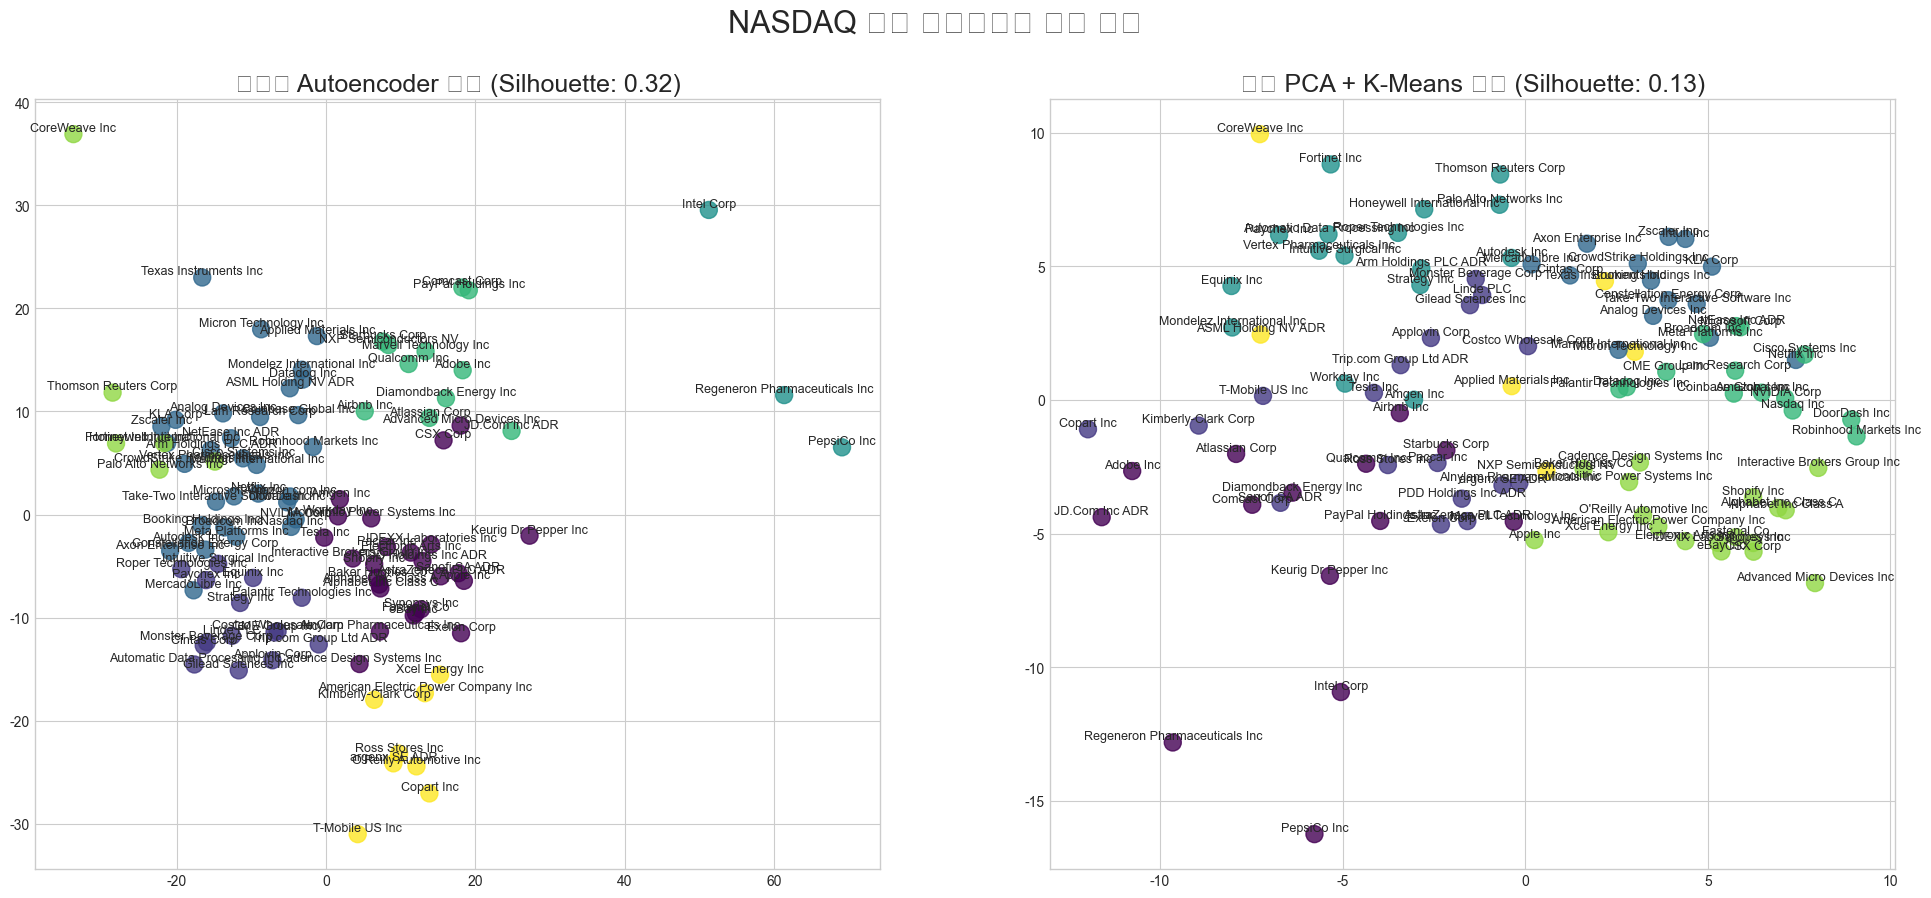

In [19]:
# ---------------------------
# ÏãúÍ∞ÅÌôî
# ---------------------------
pca_2d = PCA(n_components=2, random_state=42)
features_ae_2d = pca_2d.fit_transform(features_ae)
features_pca_2d = pca_2d.fit_transform(features_pca)

fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('NASDAQ Ï¢ÖÎ™© ÌÅ¥Îü¨Ïä§ÌÑ∞ÎßÅ Í≤∞Í≥º ÎπÑÍµê', fontsize=22, y=0.97)

# Îî•Îü¨Îãù Í≤∞Í≥º ÏãúÍ∞ÅÌôî
axes[0].set_title(f'Îî•Îü¨Îãù Autoencoder Î∞©Ïãù (Silhouette: {silhouette_ae:.2f})', fontsize=18)
scatter1 = axes[0].scatter(features_ae_2d[:, 0], features_ae_2d[:, 1], c=pred_ae, cmap='viridis', s=150, alpha=0.8)
for i, txt in enumerate(indices):
    axes[0].annotate(txt, (features_ae_2d[i, 0], features_ae_2d[i, 1]), fontsize=9, ha='center', va='bottom')

# Í≥†Ï†Ñ Î∞©Ïãù Í≤∞Í≥º ÏãúÍ∞ÅÌôî
axes[1].set_title(f'Í≥†Ï†Ñ PCA + K-Means Î∞©Ïãù (Silhouette: {silhouette_pca:.2f})', fontsize=18)
scatter2 = axes[1].scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=pred_pca, cmap='viridis', s=150, alpha=0.8)
for i, txt in enumerate(indices):
    axes[1].annotate(txt, (features_pca_2d[i, 0], features_pca_2d[i, 1]), fontsize=9, ha='center', va='bottom')

plt.show()